<a href="https://colab.research.google.com/github/RMoulla/DL_Pytorch/blob/main/TP_CNN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : CNN et ResNets sur le dataset CIFAR-10

## Objectif général

Ce TP a pour but de comprendre concrètement l’intérêt des réseaux résiduels (ResNets) en les comparant à des CNN classiques sur une tâche de classification d’images. Nous utiliserons le dataset **CIFAR-10**, composé de 60 000 images en couleur (32x32) réparties en 10 classes.

Nous allons ainsi :
- Implémenter un CNN simple pour classer les images du dataset CIFAR-10.
- Adapter un ResNet-18 pour le même dataset.
- Entraîner les deux modèles et comparer leurs performances (accuracy, perte).
- Visualiser les courbes d'apprentissage.
- Analyser les résultats en termes d’overfitting et de stabilité de l'entraînement.



## Partie I : Entraînement d'un CNN simple

Dans cette première partie, nous allons construire un modèle CNN simple et l’entraîner sur le dataset CIFAR-10. Ce modèle nous servira de référence pour évaluer ensuite l’intérêt des réseaux résiduels.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

On charge le dataset CIFAR-10 et prépare les données pour l'entraînement et le test.  
On applique une transformation standard : conversion en tenseur puis normalisation des trois canaux couleur autour de 0.  
Les `DataLoader` permettent d’itérer par batch sur les images. Le shuffle est activé pour l'entraînement.  
La variable `classes` contient la liste des 10 catégories du dataset.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes

100%|██████████| 170M/170M [01:26<00:00, 1.97MB/s]


On définit un CNN simple structuré en deux parties : des couches convolutionnelles (`conv_layers`) et des couches entièrement connectées (`fc_layers`).

- Les **convolutions** extraient des motifs visuels de plus en plus complexes. Le nombre de canaux augmente progressivement (32 → 64 → 128) car plus on avance dans le réseau, plus on souhaite capturer une grande diversité de caractéristiques (textures, formes, objets...).

- Chaque bloc contient une convolution 3×3 avec padding=1 (pour conserver la taille), suivie d’une activation ReLU, puis d’un **max pooling** 2×2 qui divise par 2 la taille spatiale (hauteur et largeur).  
  Ainsi, les dimensions de l’image évoluent comme suit :
  - 32×32 (entrée) → 16×16 → 8×8 → 4×4

- Après les couches convolutionnelles, on applique `Flatten()` pour transformer le tenseur 3D (batch_size, 128, 4, 4) en vecteur 1D de taille 128×4×4 = 2048.

- Les **couches fully-connected** réalisent la classification finale :
  - Une première couche réduit la représentation à 256 dimensions (suivie d'une ReLU).
  - La dernière couche projette ce vecteur sur les 10 classes du dataset CIFAR-10.

Ce type d’architecture est classique pour les tâches de classification d’images, mais reste limité en profondeur. Il servira ici de point de comparaison avec le ResNet.


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

train_acc_list = []
test_acc_list = []

for epoch in range(10):
    loss = train(model, trainloader, optimizer, criterion)
    train_acc = evaluate(model, trainloader)
    test_acc = evaluate(model, testloader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}: Loss = {loss:.4f} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}")


Epoch 1: Loss = 1.3660 | Train Acc = 0.6392 | Test Acc = 0.6212
Epoch 2: Loss = 0.9233 | Train Acc = 0.7400 | Test Acc = 0.7027
Epoch 3: Loss = 0.7408 | Train Acc = 0.7782 | Test Acc = 0.7291
Epoch 4: Loss = 0.6157 | Train Acc = 0.8209 | Test Acc = 0.7433
Epoch 5: Loss = 0.5138 | Train Acc = 0.8599 | Test Acc = 0.7579
Epoch 6: Loss = 0.4264 | Train Acc = 0.8939 | Test Acc = 0.7638
Epoch 7: Loss = 0.3482 | Train Acc = 0.9163 | Test Acc = 0.7689
Epoch 8: Loss = 0.2742 | Train Acc = 0.9183 | Test Acc = 0.7525
Epoch 9: Loss = 0.2130 | Train Acc = 0.9456 | Test Acc = 0.7563
Epoch 10: Loss = 0.1700 | Train Acc = 0.9565 | Test Acc = 0.7483


Entraînement de notre modèle CNN sur 10 époques.

- On commence par choisir le bon device (`cuda` si disponible), puis on instancie le modèle, la fonction de perte (`CrossEntropyLoss` pour la classification multiclasse) et l’optimiseur (`Adam` avec un taux d’apprentissage de 0.001).

- La fonction `train()` réalise une passe complète sur l'ensemble d'entraînement :
  - Le modèle est mis en mode entraînement (`model.train()`).
  - Pour chaque batch, on applique une passe avant, on calcule la perte, puis on rétro-propage et on met à jour les poids.
  - La fonction retourne la perte moyenne sur l’ensemble des batches.

- La fonction `evaluate()` évalue le modèle sur un ensemble (train ou test) :
  - Le modèle est mis en mode évaluation (`model.eval()`).
  - On désactive la mise à jour des gradients (`torch.no_grad()`).
  - On calcule le taux de bonnes prédictions (accuracy).

- Une boucle d’entraînement de 10 époques :
  - À chaque epoch, on entraîne le modèle puis on évalue sa performance sur les ensembles d'entraînement et de test.
  - Les précisions sont enregistrées dans deux listes pour être visualisées ensuite.
  - Un résumé est affiché à chaque epoch : perte moyenne, accuracy sur train et test.


## Partie II : Entraînement d’un modèle ResNet-18

Dans cette seconde partie, nous allons utiliser un modèle ResNet-18 pour comparer ses performances à celles du CNN simple défini précédemment. Nous verrons comment adapter cette architecture à CIFAR-10, l’entraîner, puis évaluer sa capacité de généralisation.

### 1. Présentation de ResNet-18

ResNet-18 est un réseau profond à base de **blocs résiduels**. Contrairement aux CNN classiques, chaque bloc apprend une fonction \( F(x) \) et la combine à son entrée via une addition : \( y = F(x) + x \).  
Cette architecture facilite l’optimisation, améliore la propagation du gradient et permet d’entraîner des réseaux plus profonds sans perte de performance.

Nous allons utiliser une version adaptée à CIFAR-10 :
- Moins agressive sur les premières couches (images plus petites que celles d’ImageNet).
- Couche finale modifiée pour produire 10 classes.

On définit un modèle `ResNet18CIFAR10`, dérivée de `nn.Module`, qui adapte l’architecture standard ResNet-18 aux images de petite taille (32×32) du dataset CIFAR-10.

- Le modèle de base est importé depuis `torchvision.models.resnet18`, sans poids pré-entraînés (`weights=None`).
- La dernière couche fully-connected (`fc`) est remplacée par une couche linéaire avec 10 sorties, correspondant aux classes de CIFAR-10.
- La première couche convolutionnelle est modifiée :
  - On remplace la convolution initiale 7×7 (trop large pour des images 32×32) par une convolution 3×3 avec stride 1 et padding 1.
- Le `maxpool` qui suit habituellement cette première convolution est supprimé (`nn.Identity()`), car il réduit trop rapidement la résolution des images à cette échelle.

Cette version modifiée conserve la structure des blocs résiduels tout en étant mieux adaptée à un dataset à faible résolution.


In [5]:
from torchvision.models import resnet18

In [6]:
class ResNet18CIFAR10(nn.Module):
    def __init__(self):
        super(ResNet18CIFAR10, self).__init__()
        self.model = resnet18(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

        # Adapter la première convolution (ImageNet = 224x224, CIFAR10 = 32x32)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # on supprime le maxpool trop destructif à cette échelle

    def forward(self, x):
        return self.model(x)

Préparation de l’entraînement du modèle ResNet-18 :

- `device` sélectionne automatiquement un GPU s’il est disponible, sinon la CPU.
- `resnet_model = ResNet18CIFAR10().to(device)` instancie le modèle adapté à CIFAR-10 et l’envoie sur le bon device.
- `criterion = nn.CrossEntropyLoss()` définit la fonction de perte, adaptée à une tâche de classification multiclasse.
- `optimizer = optim.Adam(...)` crée l’optimiseur Adam, avec un taux d’apprentissage de 0.001. Il mettra à jour l’ensemble des paramètres du modèle au fil de l'entraînement.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = ResNet18CIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)


On entraîne ici notre modèle ResNet-18 pendant 10 époques, en suivant la même logique que pour le CNN :

- À chaque époque :
  - On entraîne le modèle sur l’ensemble d'entraînement (fonction `train()`).
  - On évalue la précision sur les ensembles d'entraînement et de test.
  - Les deux valeurs sont stockées dans des listes pour pouvoir tracer les courbes ultérieurement.
  - Un résumé est affiché avec la perte moyenne et les deux scores de précision.

Les résultats obtenus pourront être comparés directement à ceux du CNN, afin d’évaluer l’impact des blocs résiduels sur la performance et la capacité de généralisation.


In [8]:
resnet_train_acc = []
resnet_test_acc = []

for epoch in range(10):
    loss = train(resnet_model, trainloader, optimizer, criterion)
    train_acc = evaluate(resnet_model, trainloader)
    test_acc = evaluate(resnet_model, testloader)

    resnet_train_acc.append(train_acc)
    resnet_test_acc.append(test_acc)

    print(f"[ResNet] Epoch {epoch+1}: Loss = {loss:.4f} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}")


[ResNet] Epoch 1: Loss = 1.1882 | Train Acc = 0.7188 | Test Acc = 0.6951
[ResNet] Epoch 2: Loss = 0.7152 | Train Acc = 0.8014 | Test Acc = 0.7586
[ResNet] Epoch 3: Loss = 0.5333 | Train Acc = 0.8051 | Test Acc = 0.7664
[ResNet] Epoch 4: Loss = 0.4107 | Train Acc = 0.8933 | Test Acc = 0.8127
[ResNet] Epoch 5: Loss = 0.3104 | Train Acc = 0.8985 | Test Acc = 0.8007
[ResNet] Epoch 6: Loss = 0.2221 | Train Acc = 0.9205 | Test Acc = 0.8071
[ResNet] Epoch 7: Loss = 0.1735 | Train Acc = 0.9524 | Test Acc = 0.8207
[ResNet] Epoch 8: Loss = 0.1192 | Train Acc = 0.9747 | Test Acc = 0.8387
[ResNet] Epoch 9: Loss = 0.0935 | Train Acc = 0.9739 | Test Acc = 0.8328
[ResNet] Epoch 10: Loss = 0.0763 | Train Acc = 0.9847 | Test Acc = 0.8426


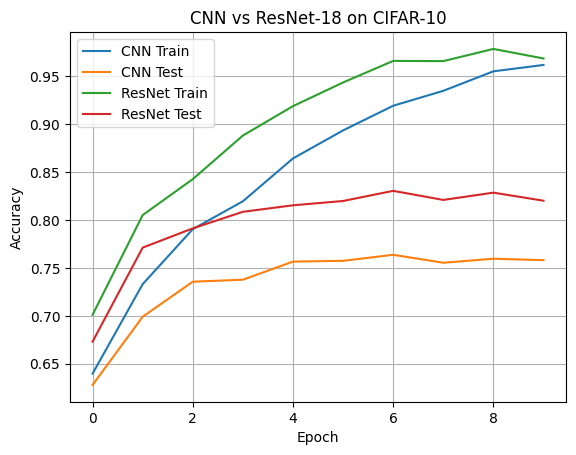

In [ ]:
plt.plot(train_acc_list, label='CNN Train')
plt.plot(test_acc_list, label='CNN Test')
plt.plot(resnet_train_acc, label='ResNet Train')
plt.plot(resnet_test_acc, label='ResNet Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN vs ResNet-18 on CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()
